In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from copy import deepcopy

# Hyper-parameter

In [2]:
config = {
    'train_ratio': 0.8,
    'batch_size': 32,
    'n_epochs': 10,
    'model': 'CNN',
    'verbose': 1
}

# model

In [3]:
class ConvolutionBlock(nn.Module):

  def __init__(self, in_channels, out_channels):
      self.in_channels = in_channels
      self.out_channels = out_channels

      super().__init__()

      self.layers = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(out_channels),
          nn.Conv2d(out_channels, out_channels, (3, 3), stride=2, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(out_channels),
      )

  def forward(self, x):
      # |x| = (batch_size, in_channels, h, w)

      y = self.layers(x)
      # |y| = (batch_size, out_channels, h, w)

      return y


class ConvolutionalNeuralNet(nn.Module):

  def __init__(self, output_size):
      self.output_size = output_size

      super().__init__()

      self.blocks = nn.Sequential( # |x| = (n, 3, 32, 32)
          ConvolutionBlock(3, 32), # (n, 32, 16, 16)
          ConvolutionBlock(32, 64), # (n, 64, 8, 8)
          ConvolutionBlock(64, 128), # (n, 128, 4, 4)
          ConvolutionBlock(128, 256), # (n, 256, 2, 2)
          ConvolutionBlock(256, 512), # (n, 512, 1, 1)
      )
      self.layers = nn.Sequential(
          nn.Linear(512, 50),
          nn.ReLU(),
          nn.BatchNorm1d(50),
          nn.Linear(50, output_size),
          nn.LogSoftmax(dim=-1),
      )

  def forward(self, x):
      assert x.dim() > 2

      if x.dim() == 3:
          # |x| = (batch_size, h, w)
          x = x.view(-1, 1, x.size(-2), x.size(-1))
      # |x| = (batch_size, 1, h, w)

      z = self.blocks(x)
      # |z| = (batch_size, 512, 1, 1)

      y = self.layers(z.squeeze())
      # |y| = (batch_size, output_size)

      return y

# utils

In [4]:
def load_cifar10(config, is_train=True):
  dataset = datasets.CIFAR10(
      '../data', train=is_train, download=True,
      transform=transforms.Compose([
          transforms.ToTensor()
      ])
  )
  if is_train:
    train_cnt = int(len(dataset)*config['train_ratio'])
    valid_cnt = len(dataset) - train_cnt

    train_dataset, valid_dataset = random_split(dataset, [train_cnt, valid_cnt])
    print("# of train_dataset : ", len(train_dataset))
    print("# of valid_dataset : ", len(valid_dataset))

    train_loader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'], shuffle=True)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=config['batch_size'])

    return train_loader, valid_loader

  else:
    test_loader = DataLoader(dataset=dataset, batch_size=config['batch_size'])
    print("# of test_dataset : ", len(dataset))
    return test_loader

# trainer

In [ ]:
class Trainer():

  def __init__(self, model, optimizer, crit):
      self.model = model
      self.optimizer = optimizer
      self.crit = crit

      super().__init__()

  def _train(self, train_loader, config):
      self.model.train()

      total_loss = 0

      for i, (x_i, y_i) in enumerate(train_loader):
          y_hat_i = self.model(x_i)
          loss_i = self.crit(y_hat_i, y_i.squeeze())

          # Initialize the gradients of the model.
          self.optimizer.zero_grad()
          loss_i.backward()

          self.optimizer.step()
          
          if config['verbose'] >= 2:
              print("Train Iteration(%d/%d): loss=%.4e" % (i + 1, len(train_loader), float(loss_i)))

          # Don't forget to detach to prevent memory leak.
          total_loss += float(loss_i)

      return total_loss / len(train_loader)

  def _validate(self, valid_loader, config):
      # Turn evaluation mode on.
      self.model.eval()

      # Turn on the no_grad mode to make more efficintly.
      with torch.no_grad():
          total_loss = 0

          for i, (x_i, y_i) in enumerate(valid_loader):
              y_hat_i = self.model(x_i)
              loss_i = self.crit(y_hat_i, y_i.squeeze())
              
              if config['verbose'] >= 2:
                  print("Valid Iteration(%d/%d): loss=%.4e" % (i + 1, len(valid_loader), float(loss_i)))

              total_loss += float(loss_i)

          return total_loss / len(valid_loader)

  def train(self, train_loader, valid_loader, config):
      lowest_loss = np.inf
      best_model = None

      for epoch_index in range(config['n_epochs']):
          train_loss = self._train(train_loader, config)
          valid_loss = self._validate(valid_loader, config)

          # You must use deep copy to take a snapshot of current best weights.
          if valid_loss <= lowest_loss:
              lowest_loss = valid_loss
              best_model = deepcopy(self.model.state_dict())

          print("Epoch(%d/%d): train_loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e" % (
              epoch_index + 1,
              config['n_epochs'],
              train_loss,
              valid_loss,
              lowest_loss,
          ))

      # Restore to best model.
      self.model.load_state_dict(best_model)


# train

In [ ]:
def main(config):
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  train_loader, valid_loader = load_cifar10(config, is_train=True)

  model = ConvolutionalNeuralNet(10)
  optimizer = optim.Adam(model.parameters())
  crit = nn.NLLLoss()

  if config['verbose'] >= 1:
    print(model)
    print(optimizer)
    print(crit)

  trainer = Trainer(model, optimizer, crit)

  trainer.train(train_loader, valid_loader, config)

  # Save best model weights
  torch.save({
      'model': trainer.model.state_dict(),
      'opt': optimizer.state_dict(),
      'config': config,
  }, config['model'] + '.pth')

In [ ]:
# start 
main(config)

100%|██████████| 170498071/170498071 [00:13<00:00, 12533337.71it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
# of train_dataset :  40000
# of valid_dataset :  10000
ConvolutionalNeuralNet(
  (blocks): Sequential(
    (0): ConvolutionBlock(
      (layers): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ConvolutionBlock(
      (layers): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(64, eps=1e-05, momen

# test

In [5]:
model_fn = "./CNN.pth"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
label_di = {
    0 : '비행기',
    1 : '자동차',
    2 : '새',
    3 : '고양이',
    4 : '사슴',
    5 : '개',
    6 : '개구리',
    7 : '말',
    8 : '배',
    9 : '트럭',
}

In [7]:
def load(fn, device):
  d = torch.load(fn, map_location=device)
  
  return d['model'], d['config']

In [8]:
def plot(x, y_hat):
  for i in range(x.size(0)):
      img = (np.array(x[i].detach().cpu(), dtype='float'))

      plt.imshow(np.transpose(img))
      plt.show()
      print("Predict:", label_di[int(torch.argmax(y_hat[i], dim=-1))])

In [9]:
def test(model, test_loader, to_be_shown=True):
  model.eval()
  
  correct_cnt, total_cnt = 0, 0
  with torch.no_grad():
    for x, y in test_loader:
      x, y = x.to(device), y.to(device)
      y_hat = model(x)
      correct_cnt += (y.squeeze() == torch.argmax(y_hat, dim=-1)).sum()
      total_cnt += len(x)

      if to_be_shown:
        plot(x, y_hat)

    accuracy = correct_cnt / total_cnt
    print("Accuracy: %.4f" % accuracy)

Files already downloaded and verified
# of test_dataset :  10000


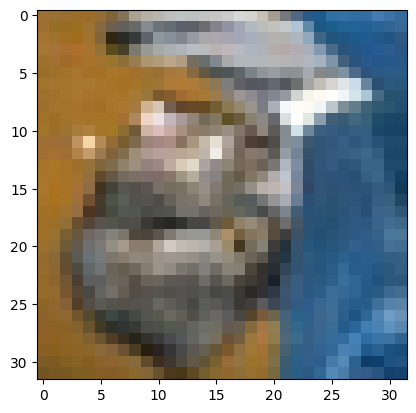

Predict: 고양이


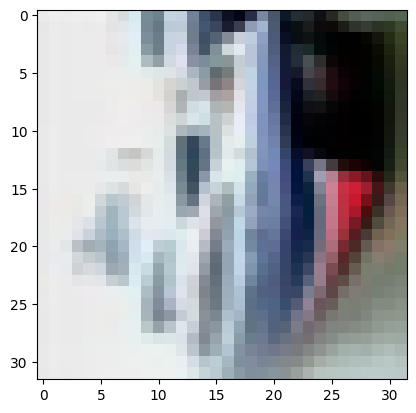

Predict: 배


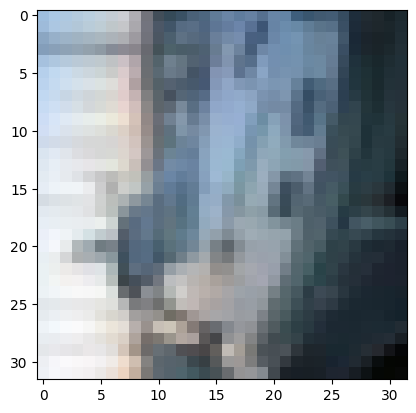

Predict: 배


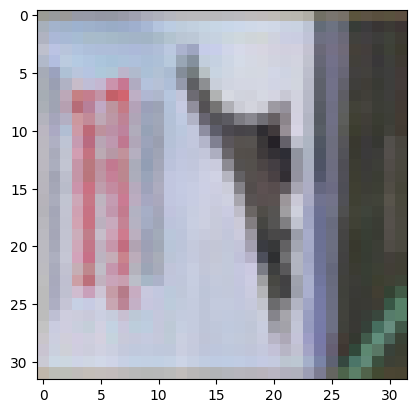

Predict: 비행기


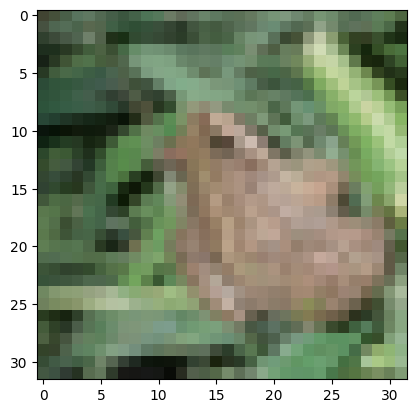

Predict: 개구리


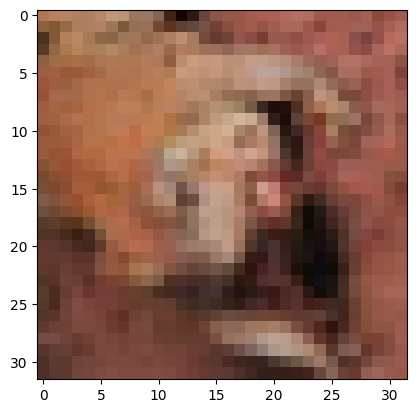

Predict: 개


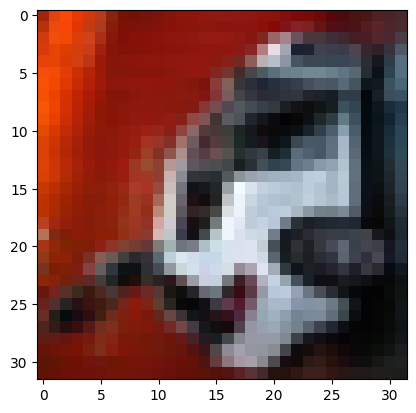

Predict: 자동차


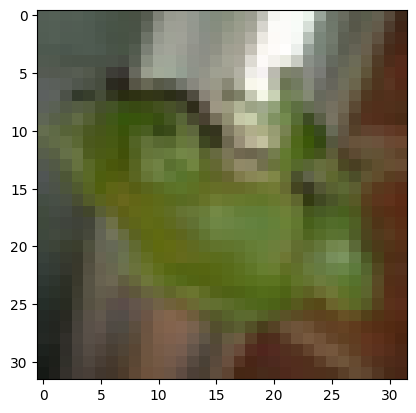

Predict: 개구리


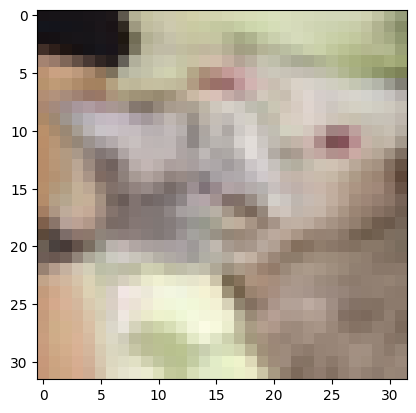

Predict: 고양이


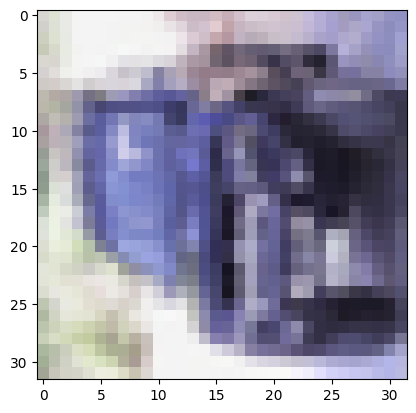

Predict: 자동차


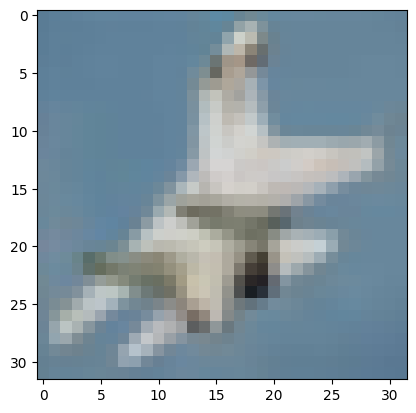

Predict: 개


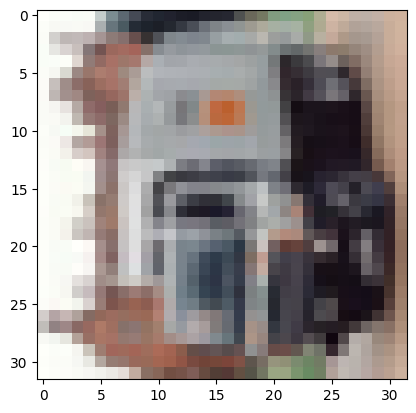

Predict: 트럭


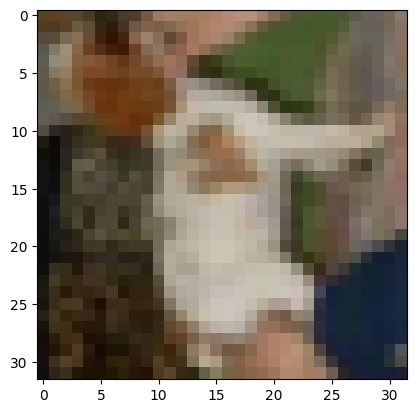

Predict: 개


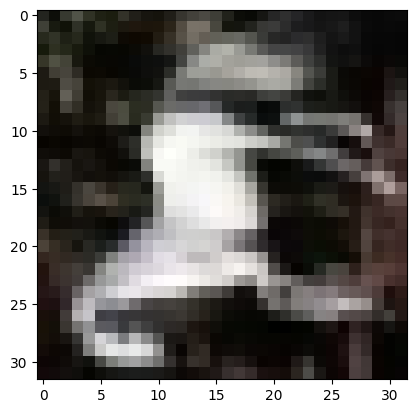

Predict: 말


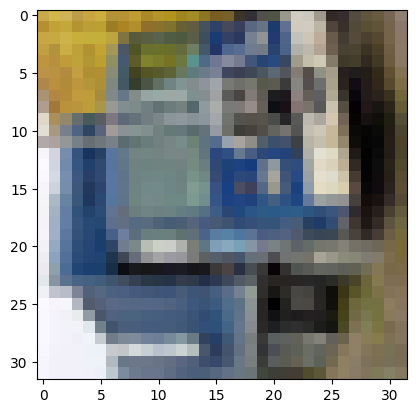

Predict: 트럭


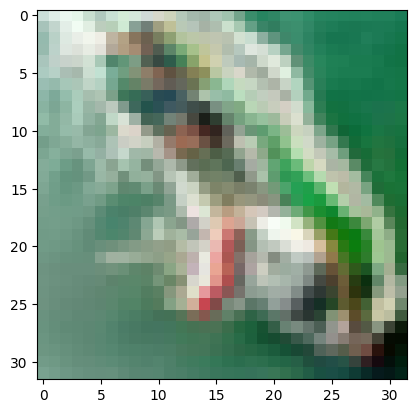

Predict: 배


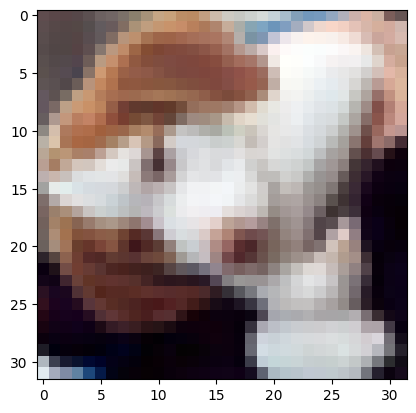

Predict: 개


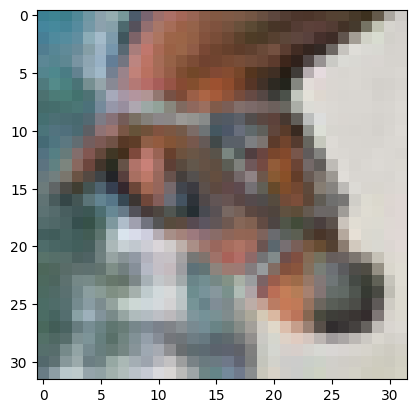

Predict: 말


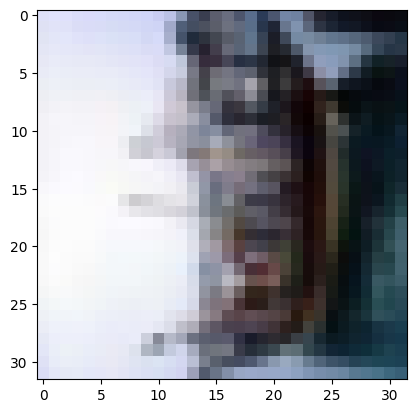

Predict: 배


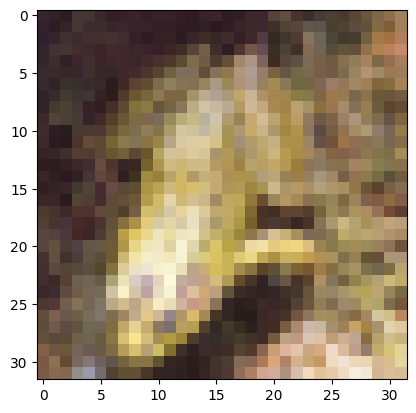

Predict: 개구리


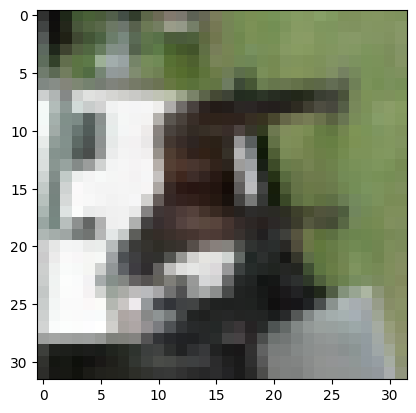

Predict: 말


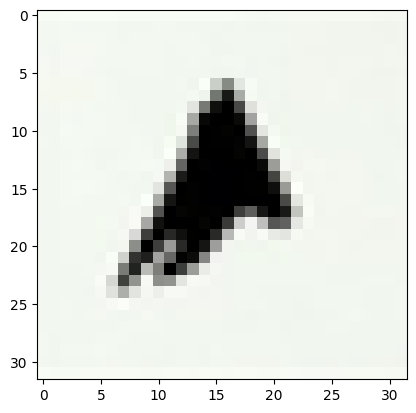

Predict: 비행기


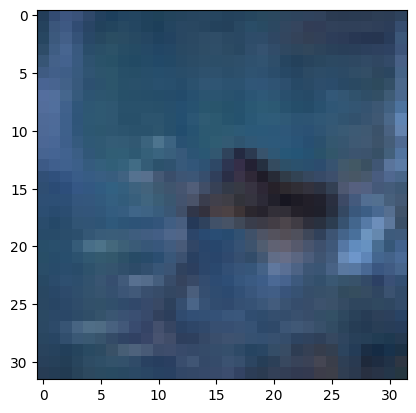

Predict: 사슴


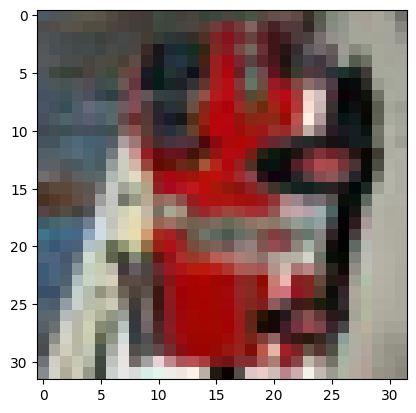

Predict: 트럭


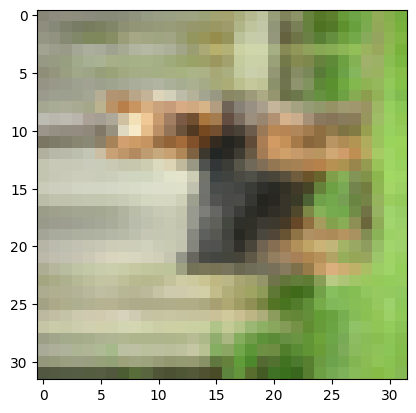

Predict: 사슴


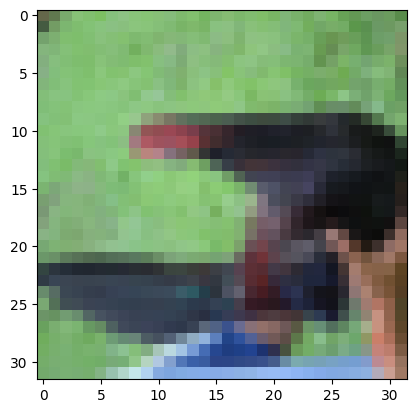

Predict: 새


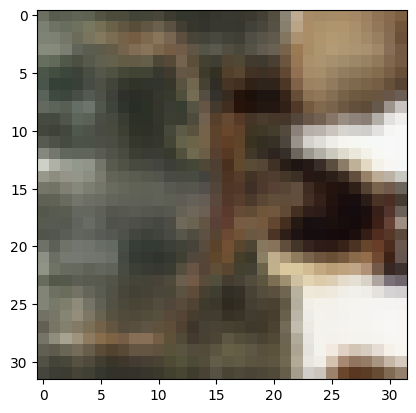

Predict: 사슴


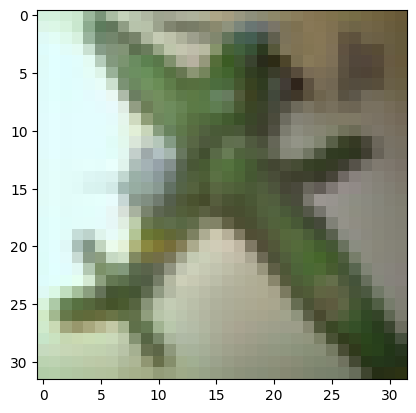

Predict: 비행기


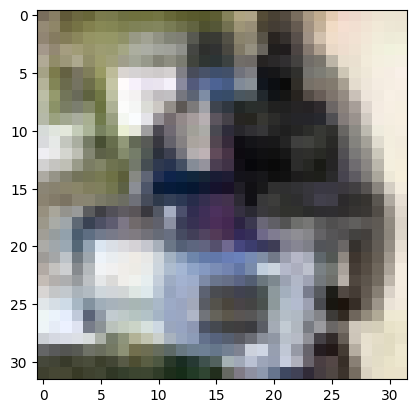

Predict: 트럭


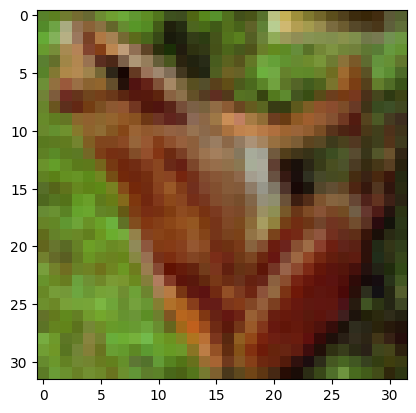

Predict: 개구리


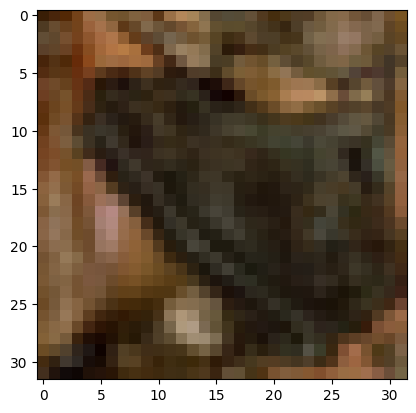

Predict: 개구리


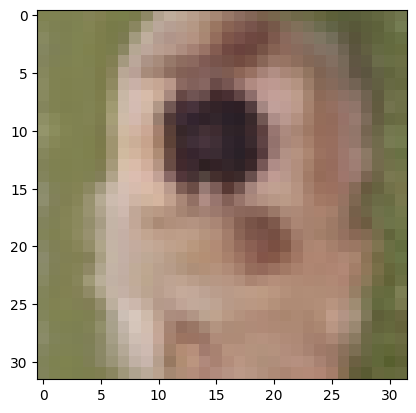

Predict: 개


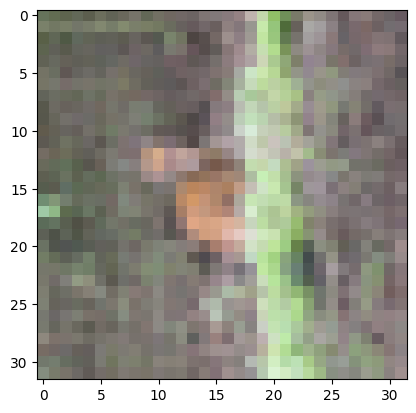

Predict: 사슴


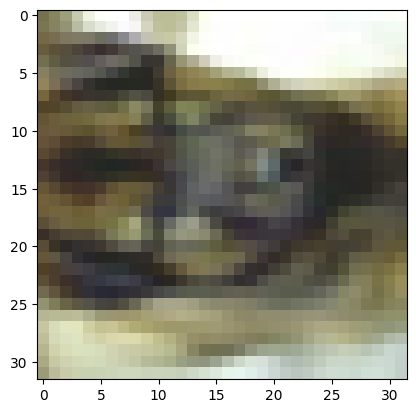

Predict: 개


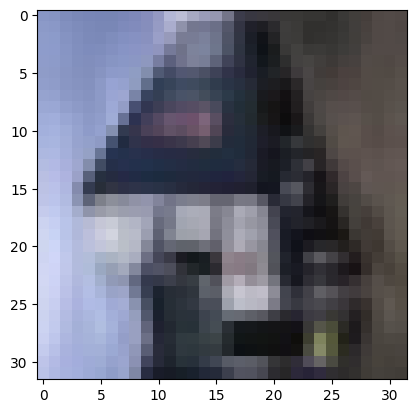

Predict: 트럭


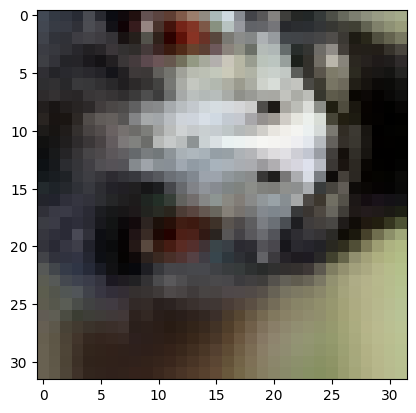

Predict: 자동차


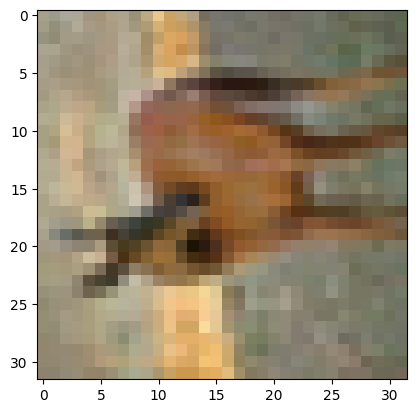

Predict: 사슴


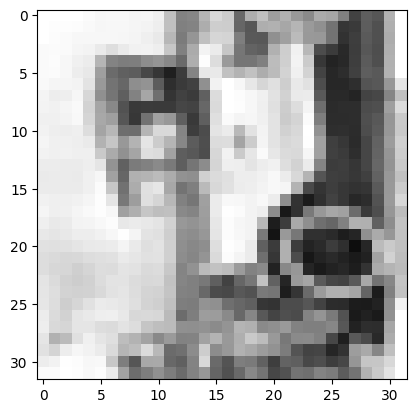

Predict: 트럭


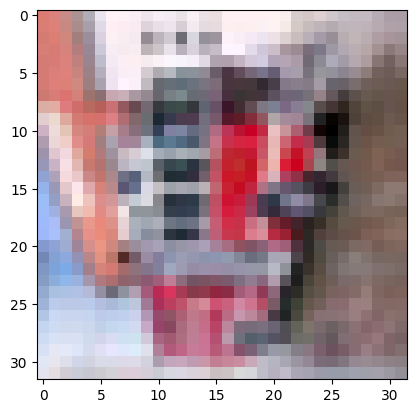

Predict: 트럭


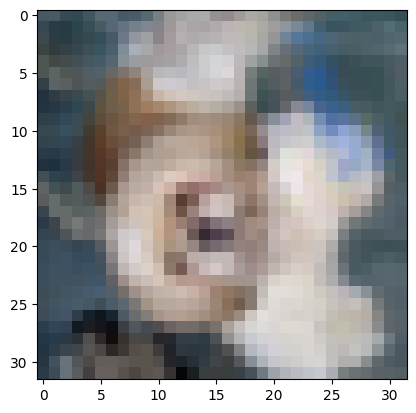

Predict: 개


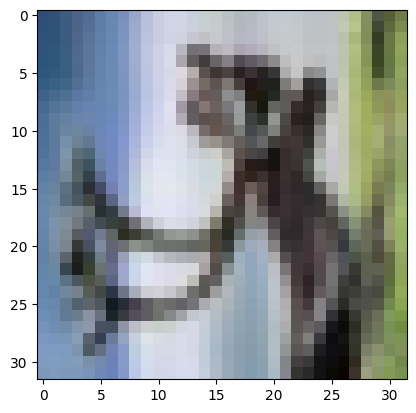

Predict: 사슴


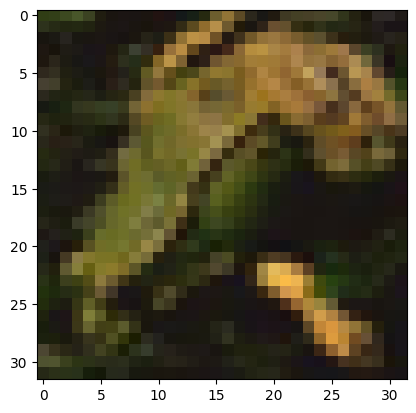

Predict: 개구리


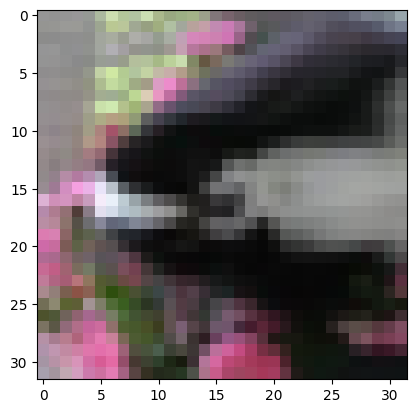

Predict: 말


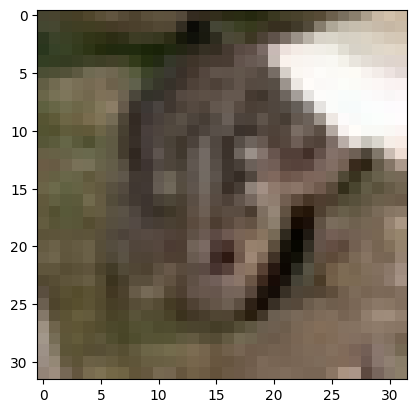

Predict: 개구리


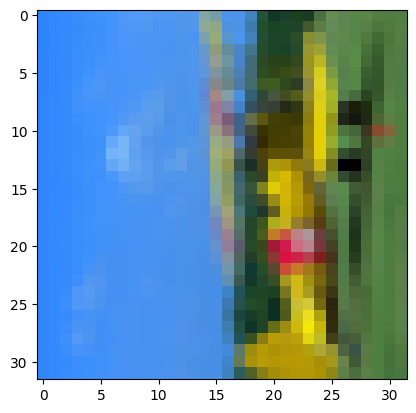

Predict: 비행기


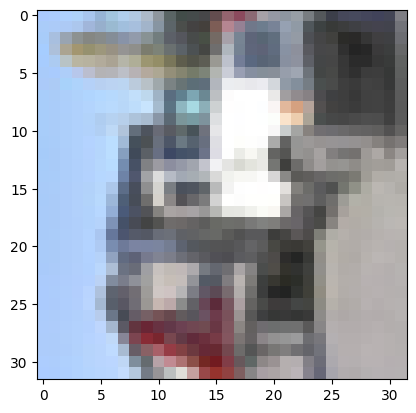

Predict: 트럭


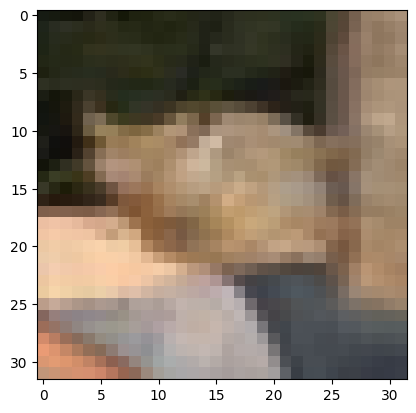

Predict: 고양이


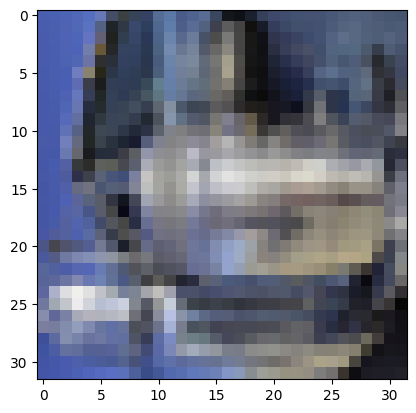

Predict: 트럭


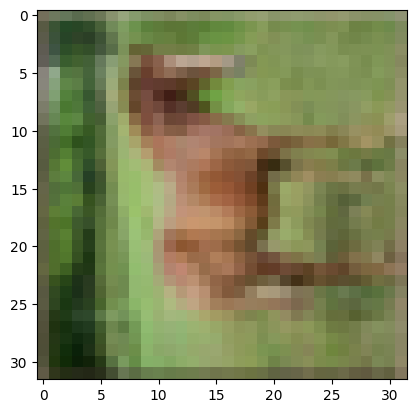

Predict: 말


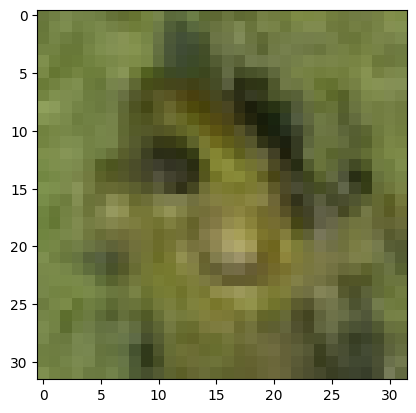

Predict: 개구리


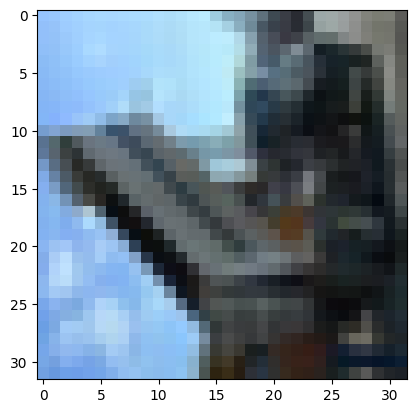

Predict: 트럭


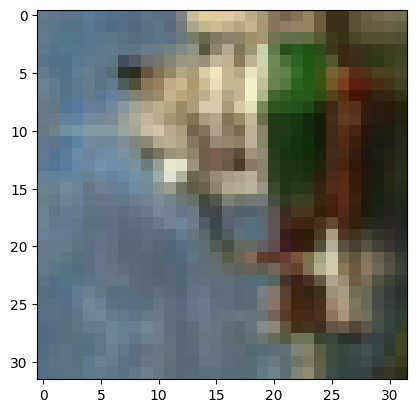

Predict: 배


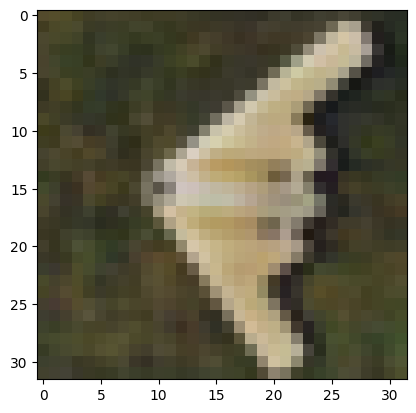

Predict: 말


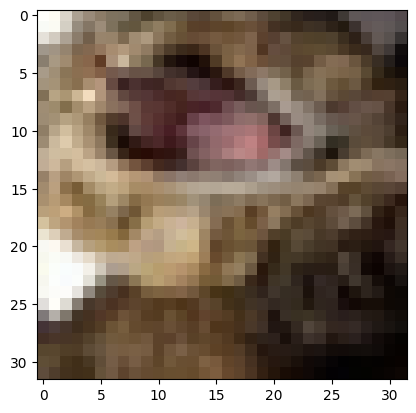

Predict: 고양이


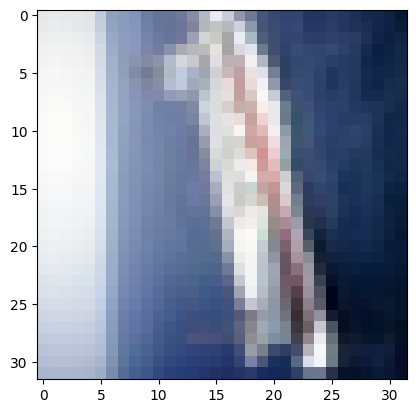

Predict: 배


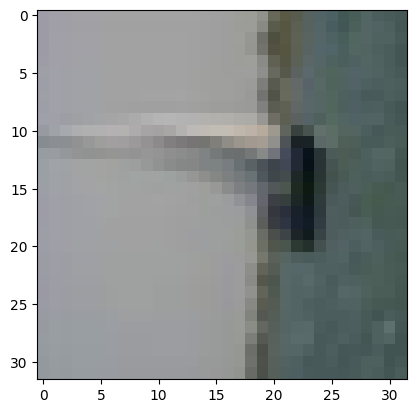

Predict: 배


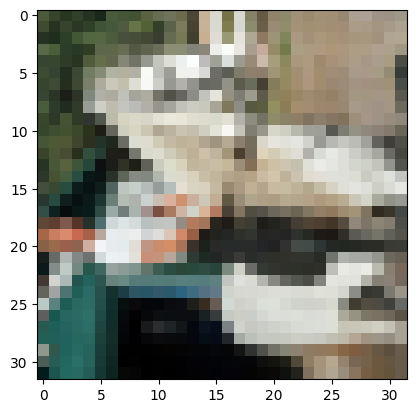

Predict: 말


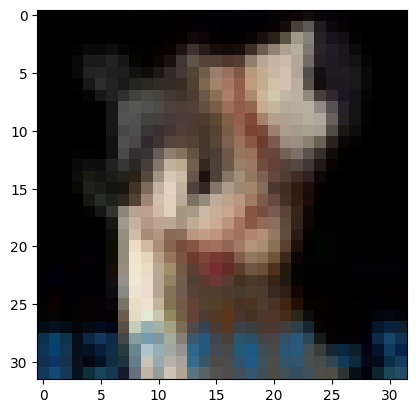

Predict: 고양이


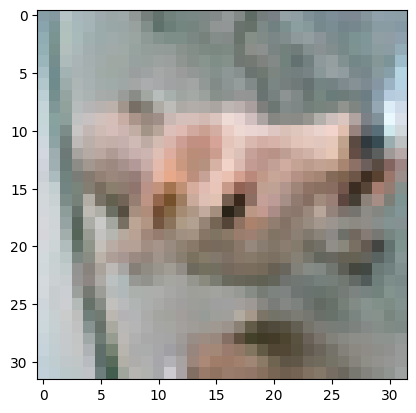

Predict: 개


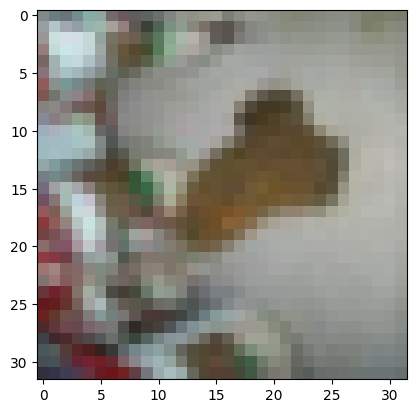

Predict: 개구리


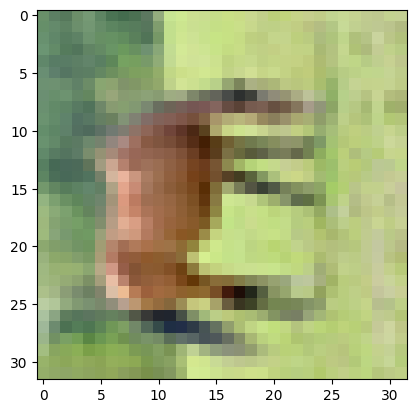

Predict: 말


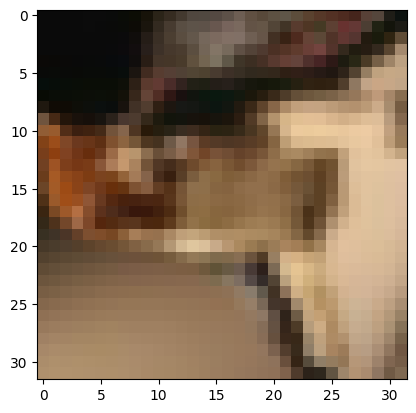

Predict: 개


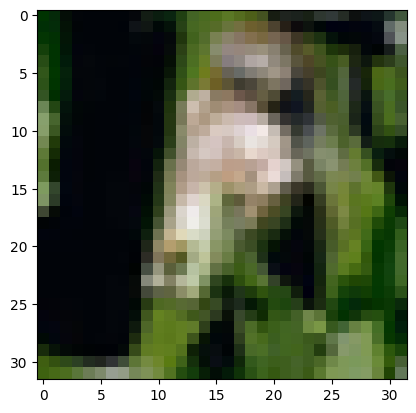

Predict: 개구리


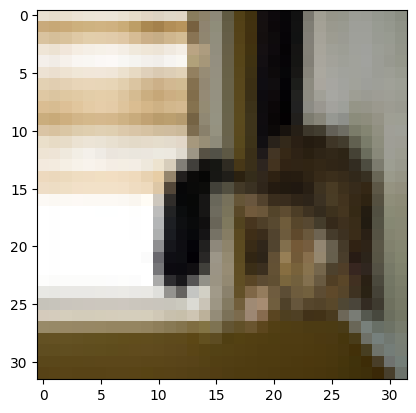

Predict: 고양이


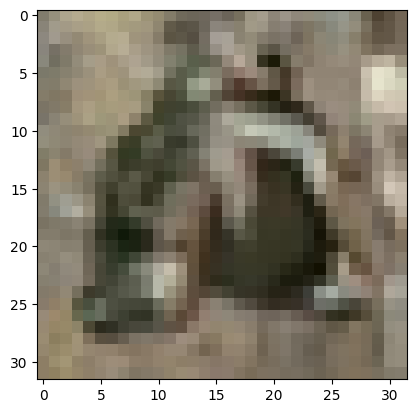

Predict: 개구리


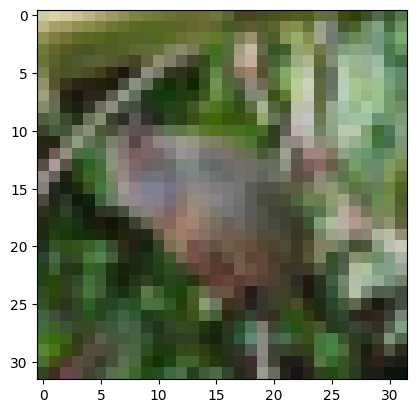

Predict: 새


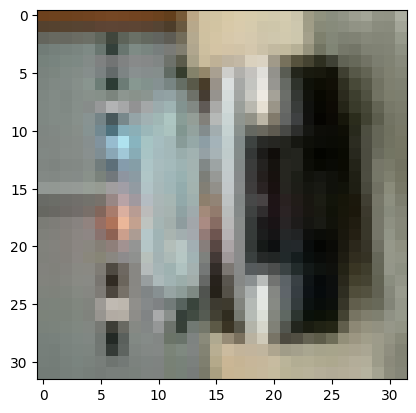

Predict: 자동차


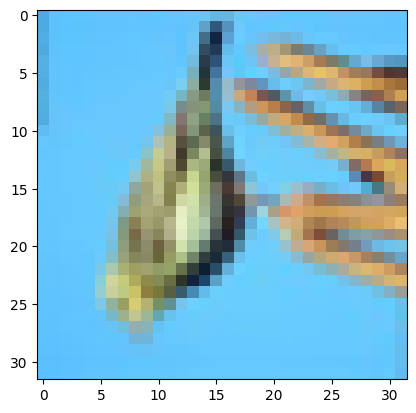

Predict: 새


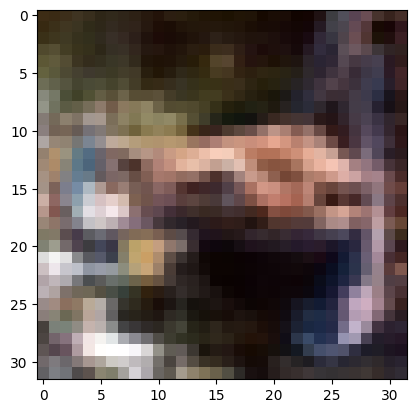

Predict: 사슴


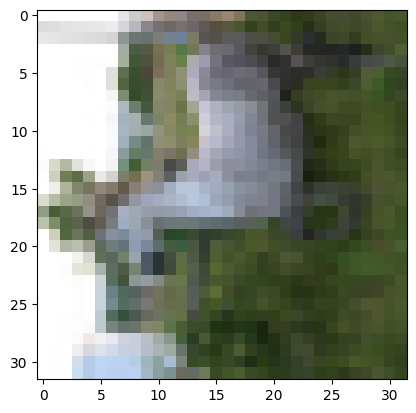

Predict: 말


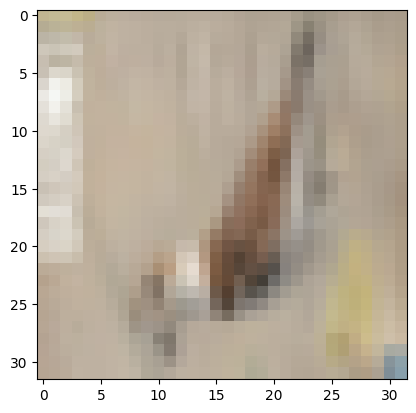

Predict: 비행기


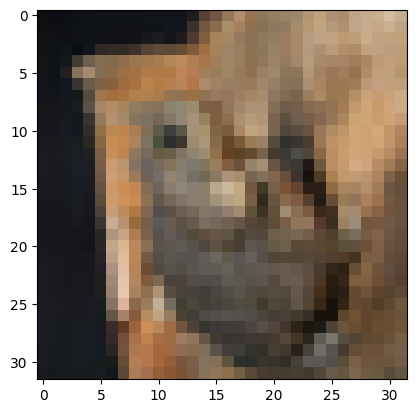

Predict: 트럭


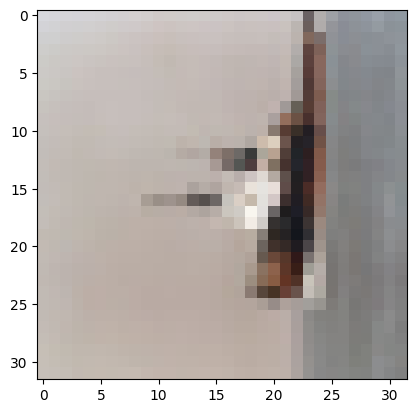

Predict: 배


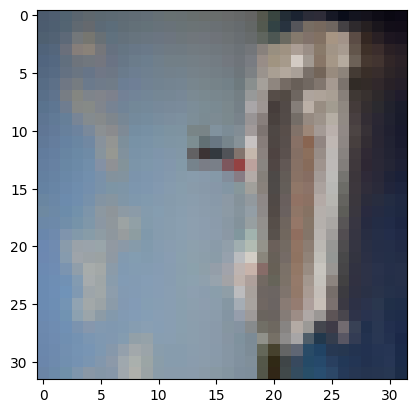

Predict: 배


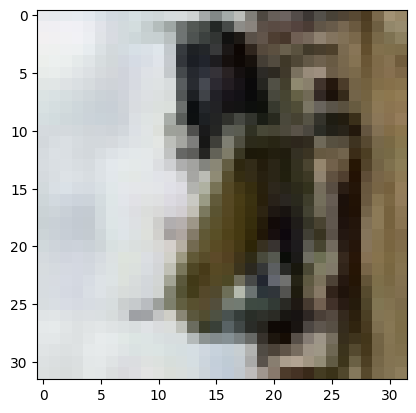

Predict: 비행기


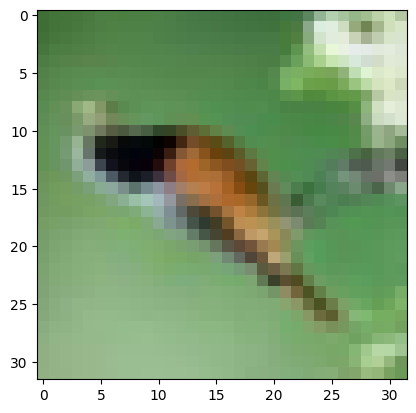

Predict: 새


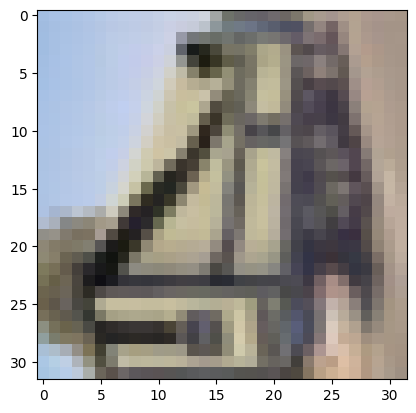

Predict: 비행기


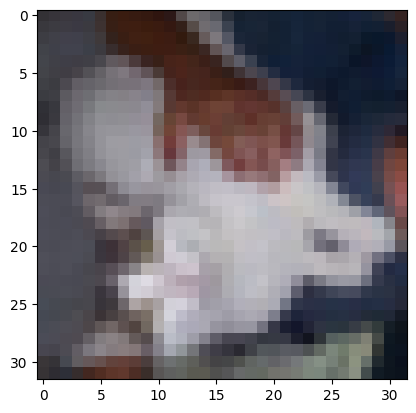

Predict: 고양이


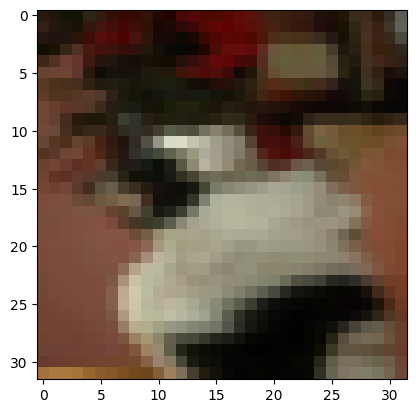

Predict: 개


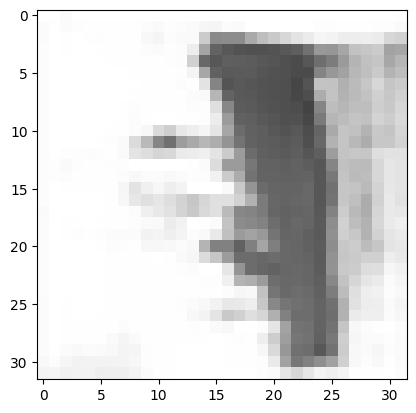

Predict: 배


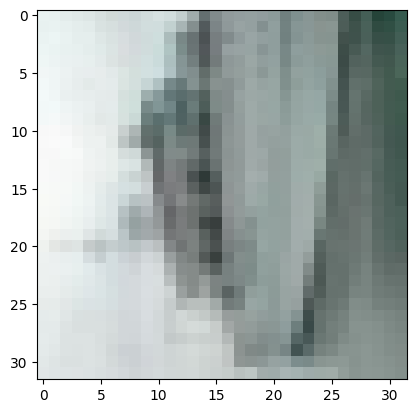

Predict: 배


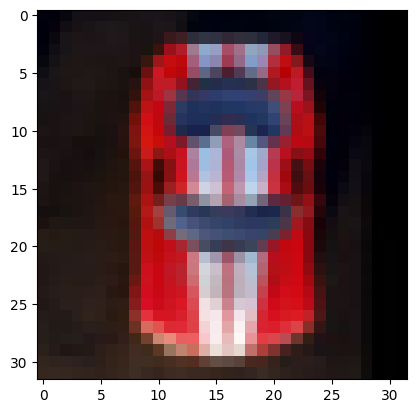

Predict: 비행기


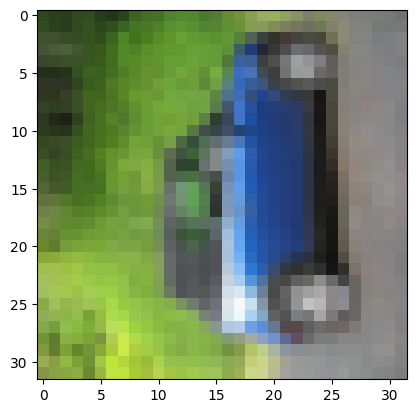

Predict: 자동차


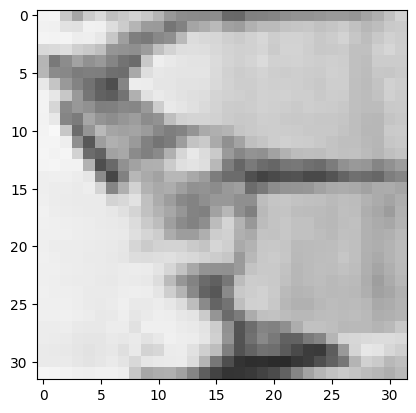

Predict: 말


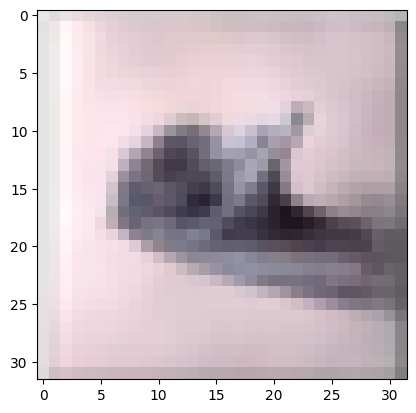

Predict: 새


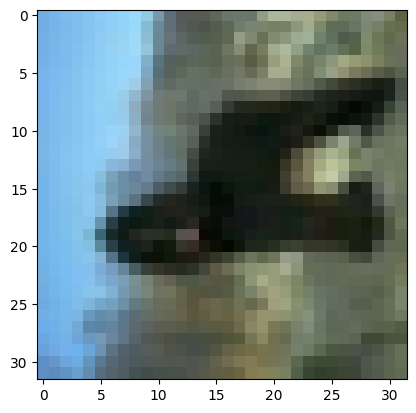

Predict: 트럭


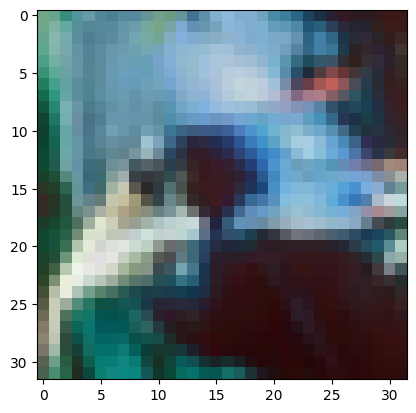

Predict: 사슴


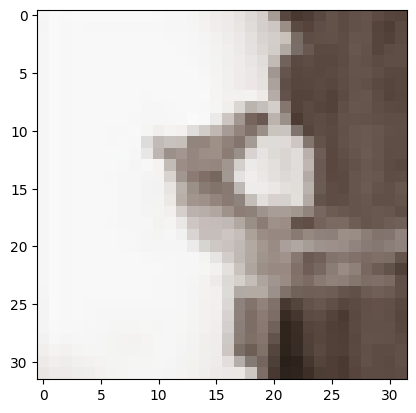

Predict: 배


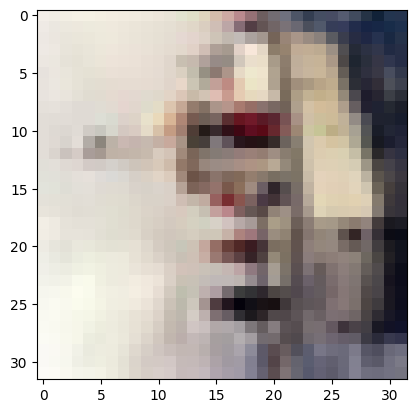

Predict: 배


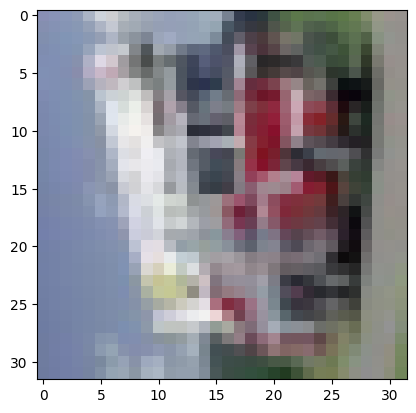

Predict: 트럭


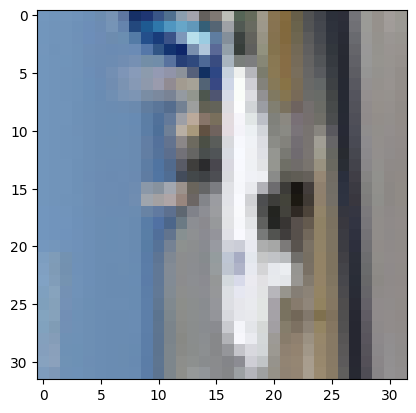

Predict: 비행기


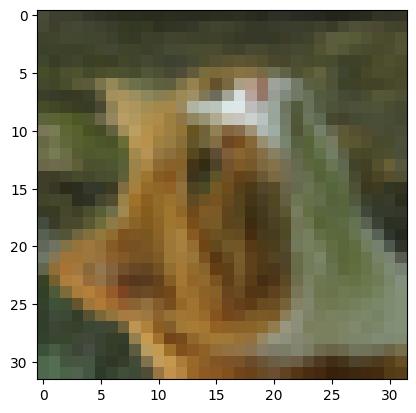

Predict: 개구리


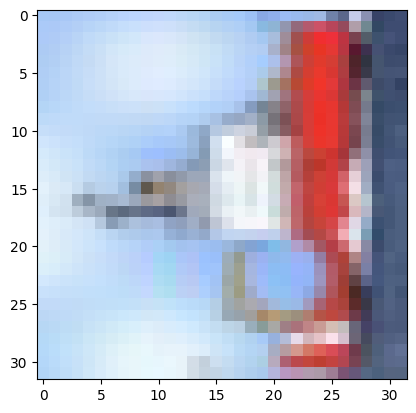

Predict: 배


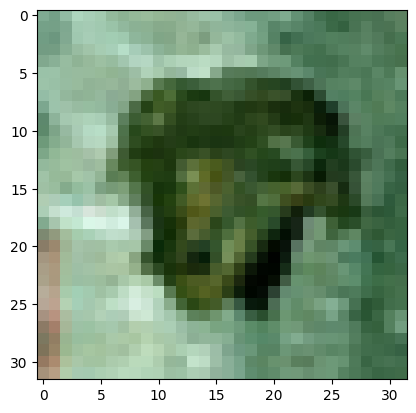

Predict: 개구리


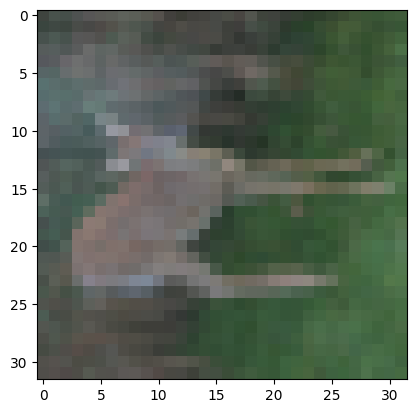

Predict: 사슴


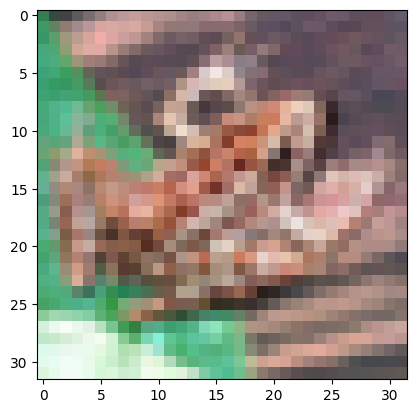

Predict: 개


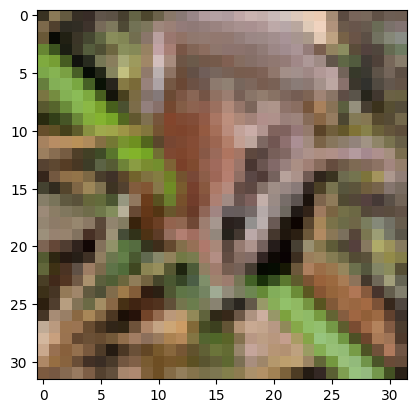

Predict: 개구리


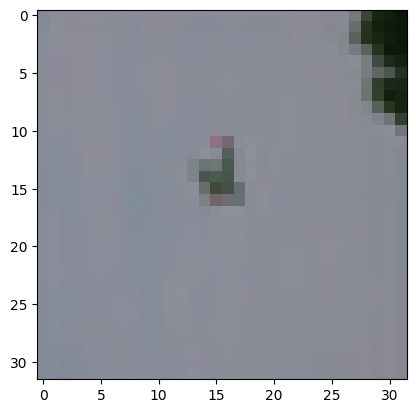

Predict: 비행기


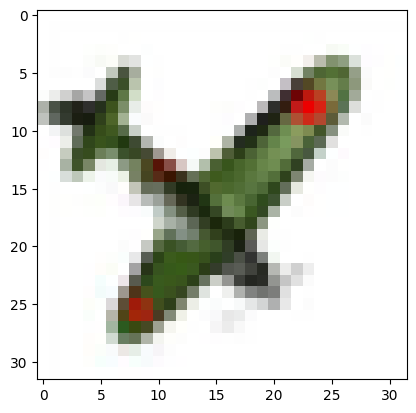

Predict: 비행기


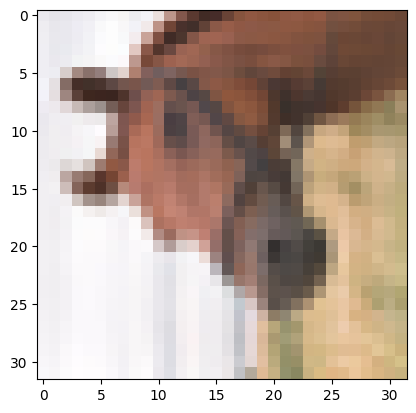

Predict: 고양이


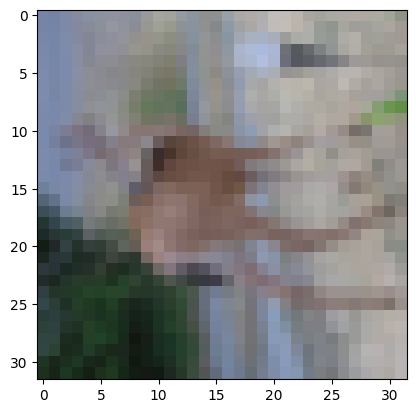

Predict: 말


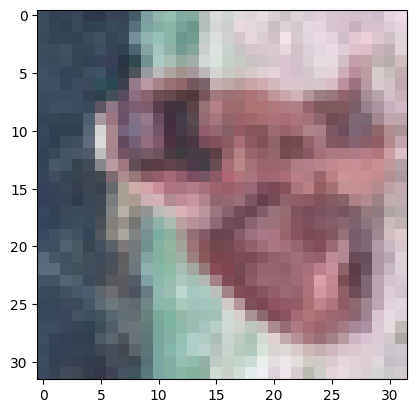

Predict: 개


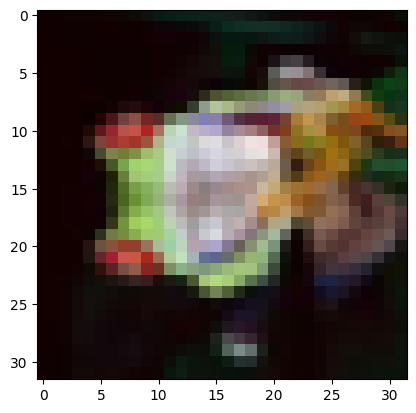

Predict: 개구리


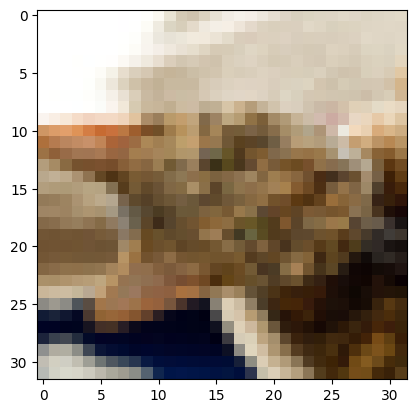

Predict: 고양이


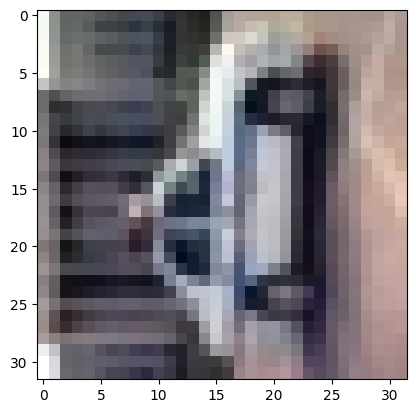

Predict: 자동차


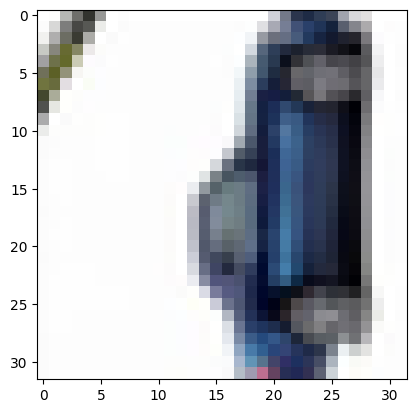

Predict: 자동차


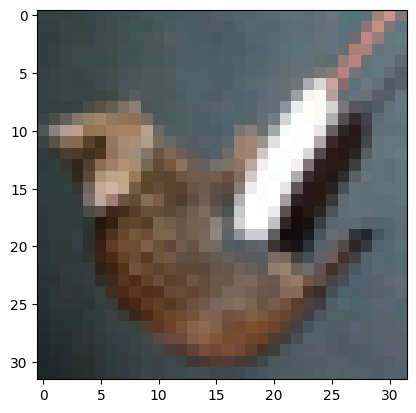

Predict: 고양이


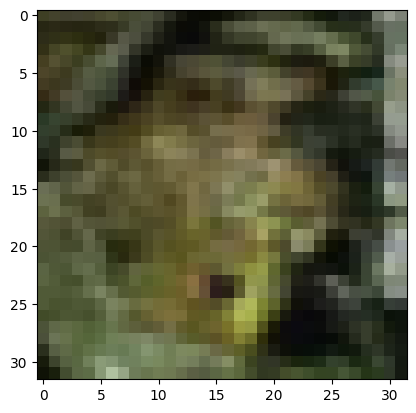

Predict: 개구리


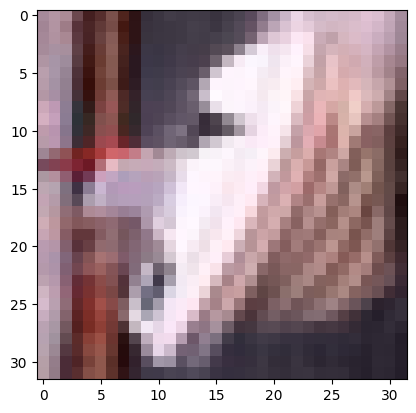

Predict: 배


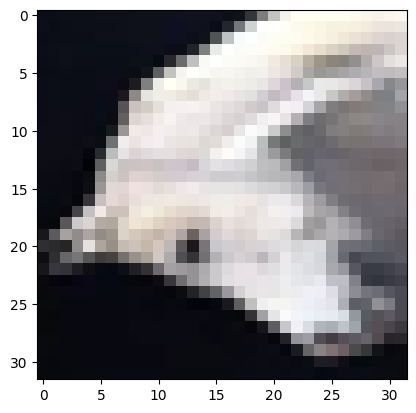

Predict: 말


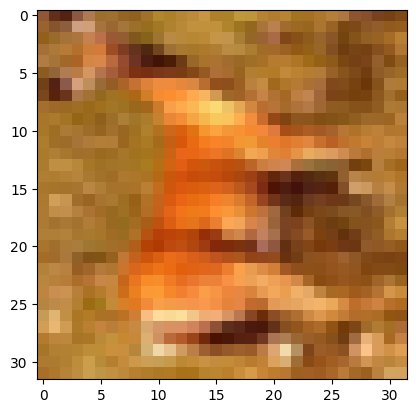

Predict: 사슴


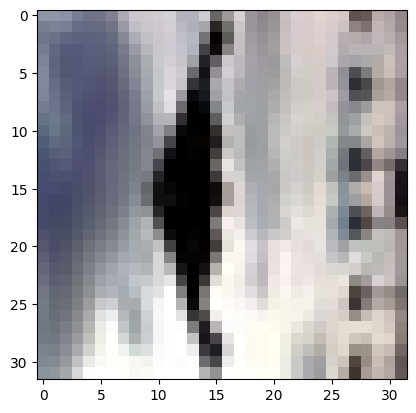

Predict: 비행기


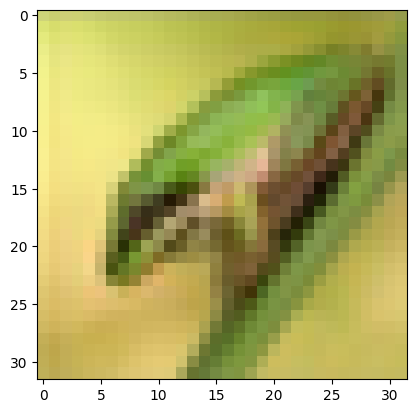

Predict: 개구리


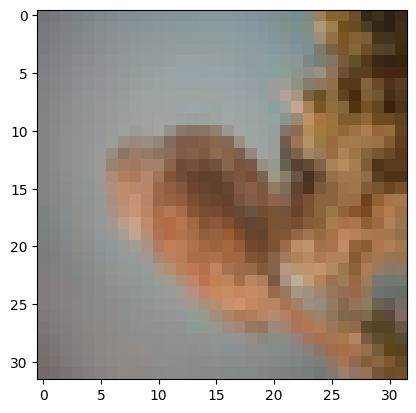

Predict: 개구리


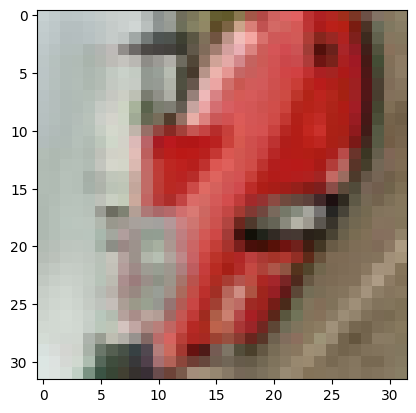

Predict: 자동차


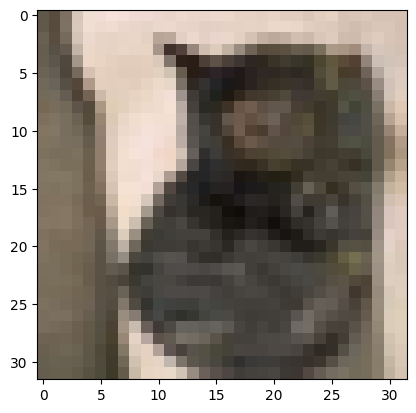

Predict: 고양이


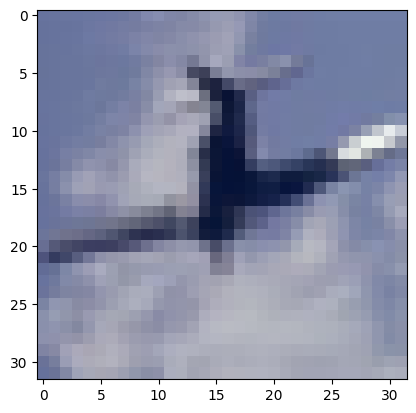

Predict: 비행기


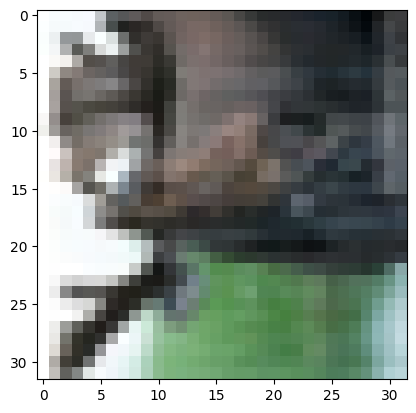

Predict: 사슴


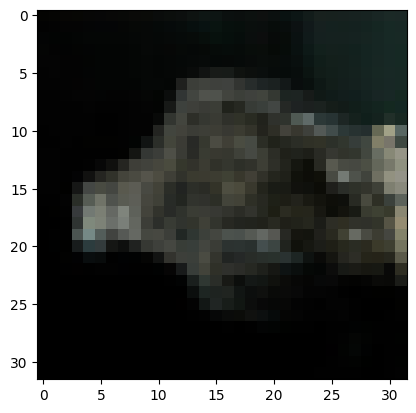

Predict: 개구리


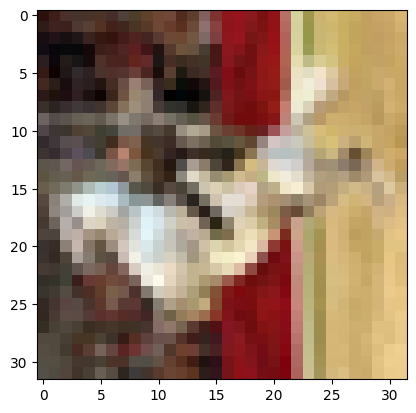

Predict: 말


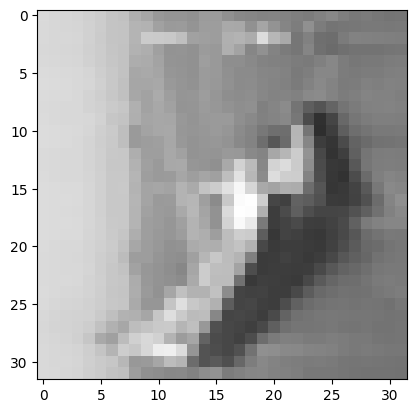

Predict: 배


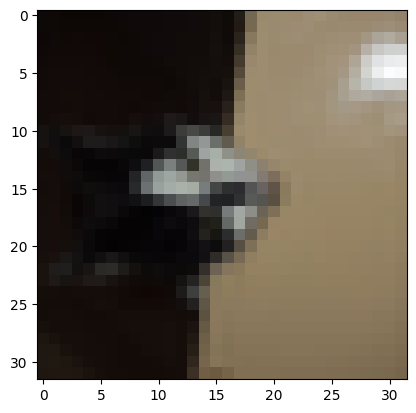

Predict: 비행기


In [ ]:
model_dict, train_config = load(model_fn, device)

test_loader = load_cifar10(config, is_train=False)
model = ConvolutionalNeuralNet(10).to(device)
model.load_state_dict(model_dict)

test(model, test_loader, to_be_shown=True)